# Machine Learning

# Introduction

The market for online advertisement has been growing rapidly in recent years. It becomes more and more crucial for companies to have a perfectly working online presence and effectively attract customers via internet campaigns to remain competitive. To assure these objectives, it is necessary to understand customers better than competitors and predict customers’ behaviour and interest. Especially with access to a growing amount of data, it seems possible to learn about those aspects and make use of the generated knowledge.

The presented project report is the result of the analysis of the given dataset about (potential) subscribers of a company’s product that was advertised in an online campaign. This campaign was conducted by the help of a banner that is presented to the user while browsing. The customer can subscribe to the product/service by clicking on the banner and then subscribe to manually what. In order to predict if a potential customer, a person to whom the banner is presented, indeed subscribes, this analysis has been conducted. To make the said prediction, characteristics of the potential subscriber will be considered. Those are used in various machine learning approaches throughout the following document. The aim is to create a model that predicts subscriptions with the highest possible accuracy. At first, an overview about the underlying dataset is given and an exploratory data analysis, EDA, will be conducted.

# Overview about the characteristics

* “Id”: This variable is a unique identifier for each record (potential subscriber). (integer)
* “age”: The age of the potential subscriber. (numeric)
* “job”: The job of the potential subscriber. (categorical)
* “martial”: The marital status of the potential subscriber. (categorical)
* “education”: The potential subscriber’s education. (categorical)
* “device”: The device with which the browsing has been conducted. (categorical)
* “day”: The day of the month at which the browsing has been conducted. (numeric)
* “month”: The month at which the browsing has been conducted. (numeric)
* “time_spent”: The time spent while browsing in minutes. (numeric)
* “banner_views”: How often the banner has been shown. (numeric)
* “banner_views_old”: How often an old and related banner was shown to this potential subscriber. (numeric)
* “days_elapsed_old”: Number of days that have past since the potential subscriber saw the last time a banner of an old and related campaign. (numeric)
* “outcome_old”: The success of the old and related campaign. (categorical)


* 4 features without name, the first 3 are categorical (binary) and a 4th one is numeric.

## EDA

We conduct EDA to explore data and receive some understanding of it.

In [321]:
from datetime import datetime

import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from tqdm import tqdm
from xgboost import XGBClassifier

train = pd.read_csv('MLUnige2023_subscriptions_train.csv')
test = pd.read_csv('MLUnige2023_subscriptions_test.csv')

Firstly, let's have a look on some part of data.

In [130]:
train.head()

,Id,age,job,marital,education,device,day,month,time_spent,banner_views,banner_views_old,days_elapsed_old,outcome_old,X1,X2,X3,X4,subscription
0,0,28,freelance,married,grad_school,smartphone,4,2,26.80,3,4,196,failure,0,0,1,0.072803,1
1,1,48,industrial_worker,married,university,smartphone,30,4,13.05,1,1,79,success,0,0,0,0.075454,1
2,2,27,teacher,married,university,smartphone,14,7,8.10,3,0,-1,na,0,1,1,0.068110,0
3,3,44,unemployed,divorced,university,smartphone,13,5,7.10,2,1,369,other,0,0,1,0.091942,0
4,4,29,manager,single,grad_school,smartphone,26,4,15.90,2,2,143,success,0,0,0,0.085922,1


The given data has some categorical, numerical and ordinal features.
-1 in days_elapsed_old and "na" in outcome_old are ways to replace None. Let's go deeper into the data and have a look on a basic statsitics.

In [309]:
print(f'The size of dataset: {len(train)}')

The size of dataset: 8952


In [323]:
descr = train.describe()
descr

,Id,age,day,month,time_spent,banner_views,banner_views_old,days_elapsed_old,X1,X2,X3,X4,subscription
count,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000
mean,4475.500000,41.201743,15.663762,6.207328,17.130306,2.540550,0.759160,49.403262,0.141086,0.013963,0.496984,0.086603,0.416443
std,2584.364138,11.638321,8.379622,2.509444,16.902741,2.824065,2.099277,107.365840,0.348129,0.117345,0.500019,0.030253,0.492996
min,0.000000,18.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2237.750000,32.000000,8.000000,5.000000,6.100000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.073891,0.000000
50%,4475.500000,39.000000,16.000000,6.000000,11.450000,2.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.077661,0.000000
75%,6713.250000,49.000000,21.000000,8.000000,22.500000,3.000000,0.000000,-1.000000,0.000000,0.000000,1.000000,0.087768,1.000000
max,8951.000000,95.000000,31.000000,12.000000,245.400000,63.000000,58.000000,854.000000,1.000000,1.000000,1.000000,0.810043,1.000000


* The count of rows for each of int/float features is equal to the number of rows, that indicates absence of missing values. In fact, we have missing values, but they are filled with some special values. Later we will take this issues into account and in the part where we implement data processing pipeline.
* Id is not meaningful column, we have to remove it from our data during model training.
* Mean value of subscription column is 0.41, that indicates that we have about 41% of subscriptions in the data, so the classes are balanced.
* The 75% quantile of days_elapsed_old is -1, that indicates that more than 75% of values are missed. Min and max values of month and day indicate that we have data for the almost whole year.
* Hidden features X1, X2 and X3 are binary, while the X4 is continuous.
* The minimal value of time_spent is zero, that is suspicious, but is not crucial for our analysis. The minimal value of banner_views is 1, so there are people who saw the banner, but skipped it immediately (time_spent=0).
* The minimal age is 18, so we have only adults in the dataset

Let's compare basic statistics of the train with the test dataset to be sure they have more or less similar distribution.

In [310]:
descr_test = test.describe()
descr_test

,Id,age,day,month,time_spent,banner_views,banner_views_old,days_elapsed_old,X1,X2,X3,X4
count,3837.00000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000
mean,1918.00000,41.062549,15.562679,6.106072,16.696377,2.643471,0.753714,46.994266,0.129268,0.015116,0.490748,0.086554
std,1107.79082,11.680208,8.372770,2.520295,16.489023,2.914504,2.152808,104.775190,0.335540,0.122030,0.499980,0.026763
min,0.00000,18.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.054936
25%,959.00000,32.000000,8.000000,5.000000,5.800000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.073775
50%,1918.00000,39.000000,15.000000,6.000000,11.250000,2.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.077742
75%,2877.00000,49.000000,21.000000,8.000000,21.750000,3.000000,0.000000,-1.000000,0.000000,0.000000,1.000000,0.088237
max,3836.00000,93.000000,31.000000,12.000000,138.000000,41.000000,55.000000,828.000000,1.000000,1.000000,1.000000,0.588764


Values in the table looks similar, so distribution is more or less the same and we don't have to filter train data before model fitting to have the same distribution as test.

Now let's have a look at the numerical columns' distribution.

In [322]:

numeric_columns_short = [
    'age',
    'day',
    'month',
    'time_spent',
    'banner_views',
    'banner_views_old',
    'days_elapsed_old',
    'X4',
]

g = sns.PairGrid(train[numeric_columns_short])
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

Provided chart represents that features such as time_spent, banner_views, banner_views_old, days_elapsed_old and X4 have exponential distribution with long and thin tale. It provides us with idea that some transformations, like a log transformation or box-cox, can be applied to the data to receive new features.

<Axes: >

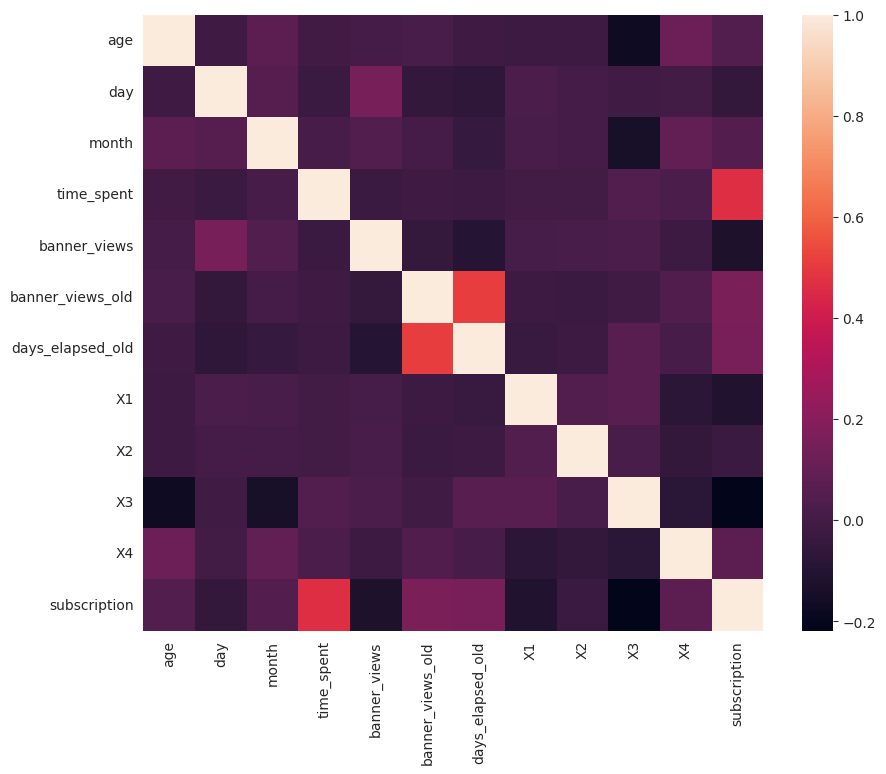

In [324]:
plt.figure(figsize=(10, 8))
all_numeric_columns = [col for col in descr if col != 'Id']
corr = train[all_numeric_columns].corr()
sns.heatmap(corr)

In [325]:
print(
    f"Correlation between banner_views_old and days_elapsed_old: {round(corr['banner_views_old']['days_elapsed_old'], 2)}")

Correlation between banner_views_old and days_elapsed_old: 0.51


In [326]:
print(
    f"Correlation between subscription and time_spent: {round(corr['subscription']['time_spent'], 2)}")

Correlation between subscription and time_spent: 0.47


As we can see, the subscription is highly correlated with time_spent. So, we expect this feature to be very important in our prediction.

Most of the features has relatively small correlations, except pairs banner_views_old - days_elapsed_old and subscription - time_spent. The fact that most correlations are small provide us with a chance of absence of multicollinearity. The last pair provide us with the idea that time_spent can be very informative. The first pair doesn't give us any meaningful insight except the fact that this pair can cause multicollinearity in data and spoil results of some models.

<Axes: xlabel='banner_views_old', ylabel='time_spent'>

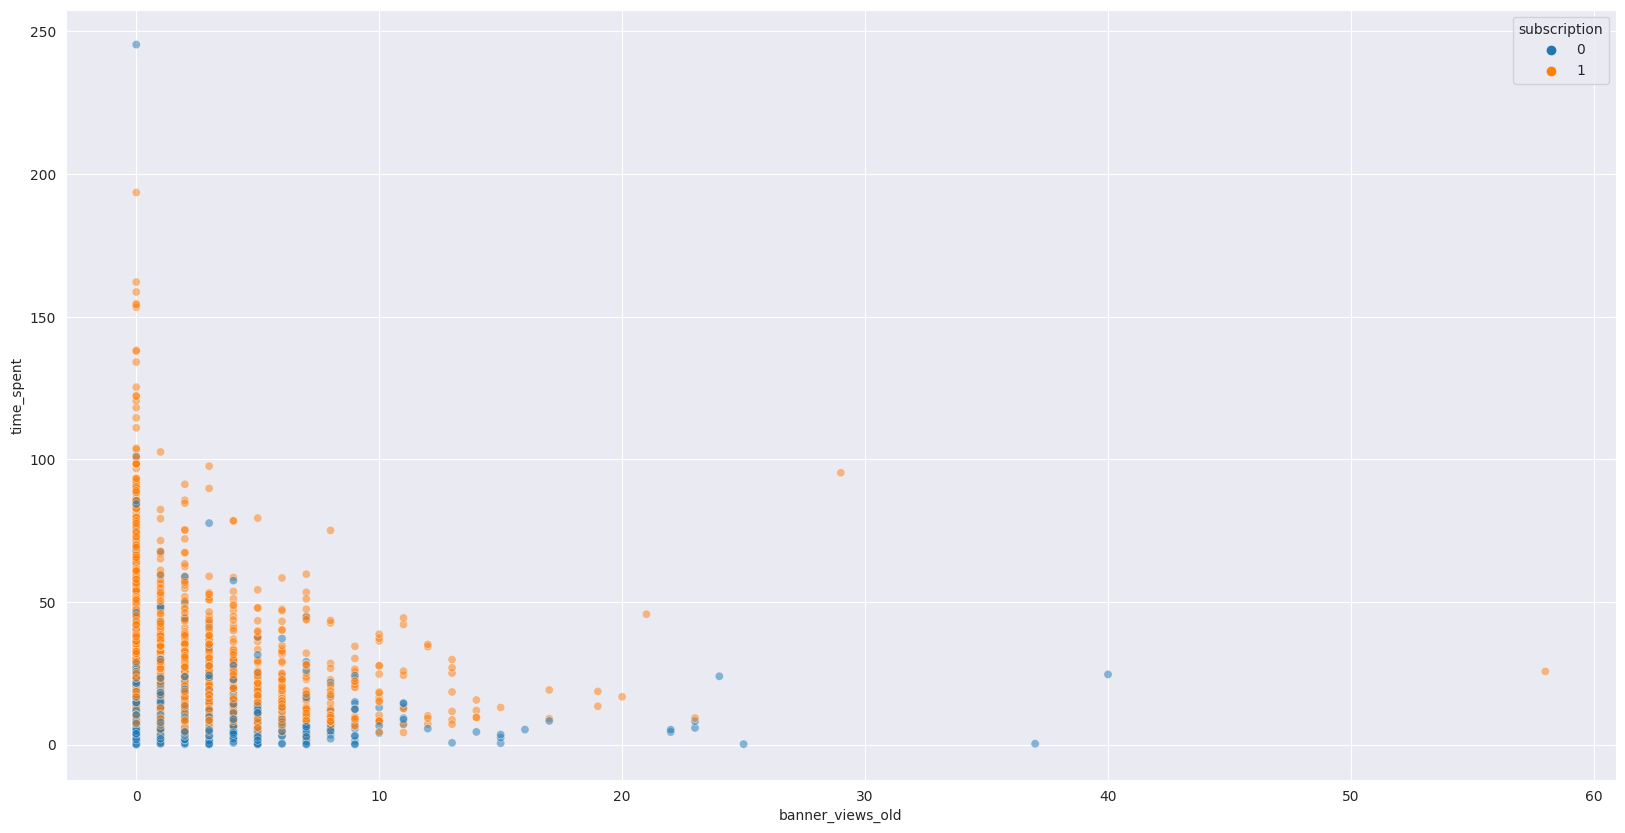

In [328]:
fig = plt.figure(figsize=(20, 10))
sns.scatterplot(
    data=train,
    x='banner_views_old',
    y='time_spent',
    hue='subscription',
    alpha=0.5
)

As we can see, time_spent features allows to separate the clusters of people who bought subscription and who didn't, while the banner_views_old feature doesn't look informative. Of course, this is not a good classification method, but it proves the importance of the feature time_spent.

Let's have a look on the categorical variables

In [135]:
categorical_columns = ['job', 'marital', 'education', 'device', 'outcome_old']
for column in categorical_columns:
    print(f'{column}: {train[column].unique()}')

job: ['freelance' 'industrial_worker' 'teacher' 'unemployed' 'manager'
 'salesman' 'technology' 'retired' 'student' 'housekeeper' 'entrepreneur'
 'na']
marital: ['married' 'divorced' 'single']
education: ['grad_school' 'university' 'high_school' 'na']
device: ['smartphone' 'na' 'desktop']
outcome_old: ['failure' 'success' 'na' 'other']


Most of the features have None value, which is represented by "na" string. We will treat this values as missed in our analysis and we will try to fill them by different methods.

## Necessary functions

Below we implemented a set of necessary method which allows to process data in the same way for train and test, and also it simplify the rest of the analysis.

### Encoding

The first method we implemented is enconding, which is necessary because we have a lot of categorical features. The method itslef is wrapper for pandas.get_dummies method with additional functionality - it replaces categorical columns from the dataset, replacing it by encoded columns. Also, the method may use predict_na_method, which predict the missed values. The predict_na_method will be explained below.

In [144]:
def encode_categorical_features(
        data,
        categorical_columns,
        predict_na,
        is_train,
        drop_columns=True
):
    """
    The method
    :param data:
    :param categorical_columns:
    :param predict_na:
    :param is_train:
    :param drop_columns:
    :return:
    """
    for col in tqdm(categorical_columns):
        if predict_na and 'na' in data[col].unique():
            pred, na_index = predict_na_method(
                dataframe=data,
                column=col,
                is_train=is_train
            )
            data[f'{col}_is_na'] = data[col] == 'na'
            data.loc[na_index, col] = pred

        new_cols = pd.get_dummies(data[col])
        if 'na' in new_cols.columns:
            new_cols = new_cols.drop(columns=['na'])
        else:
            new_cols = new_cols[new_cols.columns[:-1]]
        columns = [f'{col}_{column}' for column in new_cols.columns]
        data[columns] = new_cols
    if drop_columns:
        data.drop(columns=categorical_columns, inplace=True)

### Handle Nones

In our dataset there are a lot of features which has a big proportion of missed values. To deal with it, we tried a few approaches:
1. We kept missed values as the category "na" of for each particular feature. It is acceptable for all models, but other methods exists.
2. We tried to fill the values with the most frequent values. It is one of the most simple ways to fill missed values, and, as a result, it performs not so good in our case
3. The third approach is the most complex one - we have trained set of the models, which predicts missed values for each categorical column with "na" values. In addition, we added the columns which indicates whether the value is original or was predicted by the model, to provide estimator with information about missing values.

The last method needed implementation of additional function for prediction of missing values. The function predict_na_method is represented below:

In [274]:
predictor_models = dict()


def predict_na_method(
        dataframe,
        column,
        is_train,
        model_class=None,
        model_params=None
):
    if model_params is None:
        model_params = {}
    if model_class is None:
        model_class = CatBoostClassifier
        model_params['verbose'] = False
    columns_to_drop = categorical_columns + [column]
    if 'subscription' in dataframe.columns:
        columns_to_drop.append('subscription')
    X = dataframe.drop(columns=columns_to_drop)
    y = dataframe[column]
    na_index = y == 'na'
    X_train = X[~na_index]
    y_train = y[~na_index]
    if is_train:
        model = model_class(**model_params)
        model.fit(X_train, y_train)
        predictor_models[(column, model_class.__name__)] = model
    else:
        model = predictor_models[(column, model_class.__name__)]
    pred = model.predict(X[na_index])
    return pred, na_index


def predict_na_for_col_list(
        dataframe,
        column_list,
        is_train,
        model_class=None,
        model_params=None
):
    result = dataframe
    for col in column_list:
        result = predict_na_method(
            result,
            col,
            is_train,
            model_class,
            model_params
        )
    return result

The function has two modes - is_train and not. is_train is aplicable when the model learn the categories for prediciton, while is_train=False is used when the model predicts the missed values for each category, so it have to use the models, trained on the previous step.

### Data transformation

Below we implemented data transformation method to easily transform data. It allows to conduct experiments with data transformations and to process train and test data in the same way without any code repetitions.

The method do all necessary changes in data, the detailed list of changes is provided below.

* Encoding of categorical features. The method convert categorical features to the set of dummies, and it allows to predict missed values if the option predict_na=True is chosen. Predictors of missed values are trained on the concatenation of train and test because both of them hase correct values for the categories with missed values, so it improves performance of the model and allows to avoid overfitting on the train dataset only.
* Adding weekdays. The weekday when the person saw the banner can say a lot about the person and his site-usage scenario. To do so we have to choose any non leap year and predict the weekdays of it. In this case the first index won't mean Monday, but each index will always match the same day. This theory won't work if the actual year is a leap or if we have data for different years.
* Replace -1 in days_elapsed_old column. The -1 means missed value, but in this case -1 is not meaningful at all, because it is the smallest value, while small values means that person saw the previous banner very little time ago. To solve this problem we change this value from -1 to three years in days, because we assume that person who never the banner and the person, who saw it ver much time ago has more in common. Also, we add the binary feature never_saw_before which indicates that the person didn't see banners of the previous campaigns.

In [ ]:
def transform_data(
        data,
        is_train,
        categorical_columns,
        predict_na=False,
        add_weekday=True,
        transform_days_elapsed_old=True,
        extra_data=None
):
    dataframe = data.copy(deep=True)
    initial_length = len(data)
    if extra_data is not None:
        dataframe = pd.concat(
            [dataframe, extra_data],
            axis=0
        ).reset_index(drop=True)
    if 'Id' in dataframe.columns:
        dataframe.drop(columns=['Id'], inplace=True)
    if add_weekday:
        if 'weekday_2021' not in categorical_columns:
            categorical_columns = list(categorical_columns)
            categorical_columns.append('weekday_2021')
        dataframe['weekday_2021'] = dataframe[['month', 'day']].apply(
            lambda row: datetime(2021, row['month'], row['day']).weekday(),
            axis=1)

    encode_categorical_features(
        dataframe,
        categorical_columns,
        predict_na=predict_na,
        is_train=is_train,
    )
    if transform_days_elapsed_old:
        dataframe['never_saw_before'] = dataframe['days_elapsed_old'] == -1
        dataframe.loc[
            dataframe['days_elapsed_old'] == -1,
            'days_elapsed_old'
        ] = 365 * 3
    return dataframe.iloc[:initial_length, :]


To evaluate models and control overfitting we use the same method for all models. The method compares accuracy on train and test and shows confussion matrix.

In [295]:
def evaluate_model(model):
    predict_test = model.predict(X_test)
    predict_train = model.predict(X_train)

    accuracy_train = round(accuracy_score(y_train, predict_train), 3)
    accuracy_test = round(accuracy_score(y_test, predict_test), 3)
    print(f'{accuracy_train=}\n{accuracy_test=}')

    cm = confusion_matrix(y_test, predict_test, labels=model.classes_)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=model.classes_
    )
    disp.plot(cmap='magma')
    plt.show()

# Models

## Model 1 : Random forest

In [276]:
# Preprocess data
transformed_train = transform_data(
    train,
    predict_na=False,
    is_train=True,
    categorical_columns=categorical_columns,
    extra_data=test
)

# Separate features from labels
X = transformed_train.drop(columns=['subscription'])
y = transformed_train['subscription']

# Split the data into training and validation set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

100%|██████████| 6/6 [00:00<00:00, 330.12it/s]


In [277]:
# Initialize the random forest classifier
rf = RandomForestClassifier(random_state=42)

# Define a grid for the hyperparameter search
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform a grid search
grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=True
)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters: ", best_params)

# Retrieve the best model
best_rf = grid_search.best_estimator_

# Train and predict using the model with the best parameters
modelrf = RandomForestClassifier(**best_params)
modelrf.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


KeyboardInterrupt: 

In [278]:
evaluate_model(modelrf)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- device_smartphone
- education_university
- job_unemployed
- outcome_old_success
Feature names seen at fit time, yet now missing:
- device_is_na
- education_is_na
- job_is_na
- outcome_old_is_na


As we can see, despite good accuracy on test the model is extremely overfitted.

## Model 2 : XGboost

In [281]:

# Create a XGBClassifier model
model = XGBClassifier(
    objective='binary:logistic',  # this is for binary classification
)

# Define a grid for the hyperparameter search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7, 10],
    'n_estimators': [50, 100, 200, 500]
}

# Perform a grid search
grid_search = GridSearchCV(
    model,
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=True
)

# Fit the grid_search to the training data
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


accuracy_train=0.943
accuracy_test=0.859


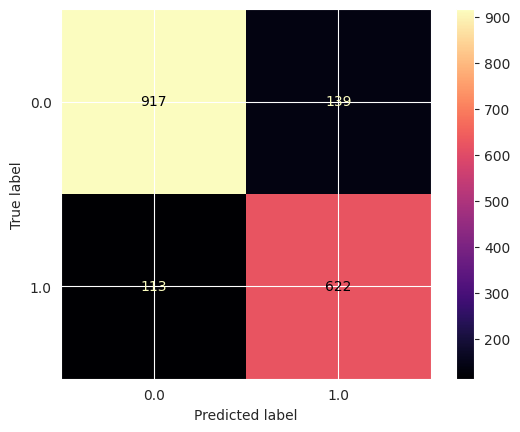

In [296]:
evaluate_model(best_xgb)

## Model 3 : CatBoost

In [283]:
best_catboost = CatBoostClassifier(
    verbose=False,
    od_type='IncToDec',
    random_seed=42
)

best_catboost.fit(X_train, y_train)

In [284]:
importance = pd.DataFrame(
    best_catboost.feature_importances_,
    index=X_train.columns,
    columns=['importance']
).sort_values(
    by='importance',
    ascending=False
)
importance

,importance
time_spent,25.991770
month,15.786392
day,8.749093
X4,6.228291
device_smartphone,5.511274
age,5.360143
days_elapsed_old,4.831195
X3,4.772655
banner_views,4.395022
outcome_old_success,3.952992


accuracy_train=0.918
accuracy_test=0.869


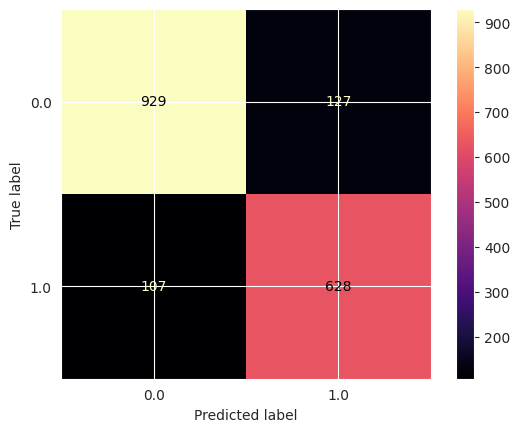

In [297]:
evaluate_model(best_catboost)

## Model 4: Logistic regression

Logistic regression belongs to the basic algorithms of machine learning in classification. The principle is not very complex and is not computational intense, compared to most other models in this report. If there are p predictors, then p + 1 model parameters are to be fitted, 1 for each predictor and 1 for the intercept, what is conducted by Bernoulli ML. Based on these fitted parameters, for each observation that is to be predicted, the probability for this instance to belong to one or the other class is calculated. In this case, there are 2 classes, “subscribed” or “not subscribed”. Therefore, if the calculated probability of belonging to class “subscribed” is larger than 0.5, the prediction will be “subscribed” and vice versa. In special cases, this cut-off value can be adapted for example, when making a Type-I error has distinct severe consequences than making a Type-II error.

In [298]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

/home/demidov-artem/PycharmProjects/MachineLearning/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

accuracy_train=0.809
accuracy_test=0.807


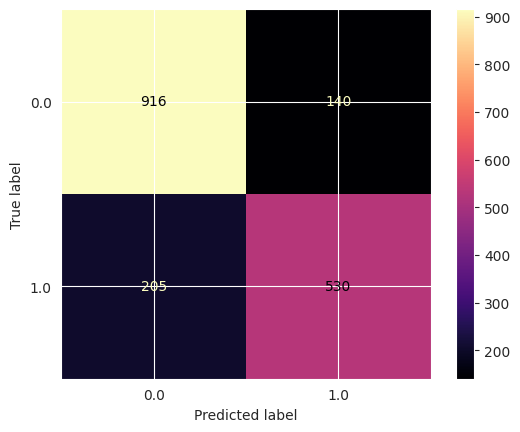

In [299]:
evaluate_model(logreg)

## Model 5: Support Vector Machines

The principle of Support Vector Machines is to find a decision boundary with p (number of predictors) -1 dimensions that separates the training data as accurate as possible. This multidimensional decision boundary it then applied to separate the test data or the any new data of interest. SVM are an enhancement or generalization of Support Vector Classifiers in a sense that they automatically widen the feature space and therefore allow for non-linear decision boundaries, compared to regular Support Vector Classifiers, where one had to create the new dimensions manually. For this, SVM use either the linear or the Kernel method while the Kernel can be as well a linear function but is not necessarily linear.

In [300]:
svm = SVC(kernel='linear', C=1.0, random_state=42, probability=True)
svm.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

accuracy_train=0.819
accuracy_test=0.805


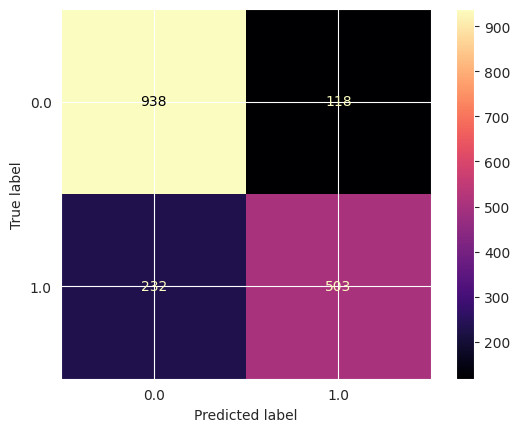

In [301]:
evaluate_model(svm)

## Ensemble of models

In [302]:
def get_extended_dataset(dataset, drop_original_columns=False):
    dataset_extended = dataset.copy()
    if drop_original_columns:
        dataset_extended = pd.DataFrame()
    dataset_extended['xgb_proba'] = best_xgb.predict_proba(dataset)[:, 0]
    dataset_extended['catboost_proba'] = best_catboost.predict_proba(dataset)[
                                         :, 0]
    dataset_extended['logreg_proba'] = logreg.predict_proba(dataset)[:, 0]
    dataset_extended['svm_proba'] = svm.predict_proba(dataset)[:, 0]
    return dataset_extended


In [303]:
X_train_extended = get_extended_dataset(X_train, True)
X_train_extended, X_val_extended, y_train_extended, y_val_extended = train_test_split(
    X_train_extended,
    y_train,
    test_size=0.3
)
X_test_extended = get_extended_dataset(X_test)

In [304]:
ensemble_model = \
    CatBoostClassifier(
        verbose=False,
        od_type='IncToDec',
        random_seed=42
    )

ensemble_model.fit(
    X_train_extended,
    y_train_extended,
    eval_set=(X_val_extended, y_val_extended)
)

In [305]:
importance = pd.DataFrame(
    ensemble_model.feature_importances_,
    index=X_train_extended.columns,
    columns=['importance']
).sort_values(
    by='importance',
    ascending=False
)
importance

,importance
xgb_proba,57.672240
catboost_proba,16.043908
svm_proba,15.621619
logreg_proba,10.662233


In [306]:
evaluate_model(ensemble_model)

CatBoostError: /src/catboost/catboost/libs/data/model_dataset_compatibility.cpp:81: At position 0 should be feature with name xgb_proba (found age).

## Generate a Kaggle submission

In [189]:
transformed_test = transform_data(
    test,
    predict_na=True,
    is_train=False,
    categorical_columns=categorical_columns
)

  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_65213/921683827.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if predict_na and 'na' in data[col].unique():
100%|██████████| 6/6 [00:00<00:00, 93.43it/s]


In [190]:
submission = test[['Id']]
submission['subscription'] = ensemble_model.predict(
    get_extended_dataset(transformed_test))
submission.head()

/tmp/ipykernel_65213/3642113573.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['subscription'] = ensemble_model.predict(


,Id,subscription
0,0,0.0
1,1,1.0
2,2,0.0
3,3,0.0
4,4,1.0


In [191]:
len(submission)

3837

In [192]:
submission.to_csv('ensemble_no_overfitting_submission.csv', index=False)